# **Module 1 and 2**

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("PS_2025.12.01_05.00.30.csv", comment="#")

df.columns = df.columns.str.strip()

df = df.drop_duplicates()

print("Shape after deduplication:", df.shape)


Shape after deduplication: (39063, 92)


In [ ]:
BASE_FEATURES = [
    "pl_name",
    "pl_rade",
    "pl_bmasse",
    "pl_orbsmax",
    "pl_eqt",
    "pl_orbper",
    "pl_insol",
    "pl_orbeccen",
    "st_teff",
    "st_rad",
    "st_mass",
    "st_met",
    "st_spectype"
]

df = df[BASE_FEATURES].copy()


In [ ]:
df['pl_rade'] = df['pl_rade'].replace(0, np.nan)


In [ ]:
df['pl_density'] = np.where(
    (df['pl_bmasse'].notna()) & (df['pl_rade'].notna()),
    (df['pl_bmasse'] / (df['pl_rade'] ** 3)) * 5.51,
    np.nan
)


In [ ]:
df['pl_density'] = df['pl_density'].replace([np.inf, -np.inf], np.nan)
df['pl_density'] = df['pl_density'].fillna(df['pl_density'].median())


In [ ]:
df['pl_density'] = df['pl_density'].clip(lower=0.5, upper=15)


In [ ]:
df["st_luminosity"] = (df["st_rad"] ** 2) * ((df["st_teff"] / 5772) ** 4)

In [ ]:
import re

df["spectral_class"] = df["st_spectype"].str.extract(r"([OBAFGKM])")


In [ ]:
import numpy as np

numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include="object").columns

df[numeric_cols] = df[numeric_cols].apply(
    lambda x: x.fillna(x.median())
)

df[categorical_cols] = df[categorical_cols].apply(
    lambda x: x.fillna(x.mode()[0])
)


In [ ]:
df = pd.get_dummies(df, columns=["spectral_class"], drop_first=True)


# **Module 3**

3.1 Create Habitability Score

In [ ]:
def safe_score(x, ideal, tol):
    return np.clip(1 - np.abs(x - ideal) / tol, 0, 1)

df['habitability_score'] = (
    0.30 * safe_score(df['pl_eqt'], 288, 200) +
    0.20 * safe_score(df['pl_rade'], 1, 1) +
    0.20 * safe_score(df['pl_bmasse'], 1, 5) +
    0.20 * safe_score(df['pl_orbsmax'], 1, 1) +
    0.10 * safe_score(df['pl_density'], 1, 3)
)


3.2 Create Classification Target

In [ ]:
threshold = df["habitability_score"].quantile(0.7)
df["habitability_class"] = (df["habitability_score"] >= threshold).astype(int)

print("Threshold:", threshold)
print(df["habitability_class"].value_counts())


Threshold: 0.15903247363095416
habitability_class
0    27343
1    11720
Name: count, dtype: int64


In [ ]:
FEATURE_PATH = "//content//exoplanet_feature_engineered_dataset.csv"
df.to_csv(FEATURE_PATH, index=False)
print("Saved:", FEATURE_PATH)


Saved: //content//exoplanet_feature_engineered_dataset.csv


3.3 Feature Selection via Pearson

In [ ]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

target = "habitability_score"

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

numeric_features.remove(target)

pearson_results = []

for feature in numeric_features:
    valid = df[[feature, target]].dropna()
    if valid[feature].nunique() > 1:
        r, p = pearsonr(valid[feature], valid[target])
        pearson_results.append((feature, r, abs(r), p))

pearson_df = pd.DataFrame(
    pearson_results,
    columns=["Feature", "Pearson_r", "AbsCorr", "p_value"]
).sort_values("AbsCorr", ascending=False)

selected_features = pearson_df[pearson_df["AbsCorr"] >= 0.2]["Feature"].tolist()

print("Selected Features (|r| >= 0.2):")
print(selected_features)

pearson_df.head(25)


Selected Features (|r| >= 0.2):
['habitability_class', 'pl_eqt', 'st_met']


,Feature,Pearson_r,AbsCorr,p_value
13,habitability_class,0.840350,0.840350,0.000000e+00
3,pl_eqt,-0.249073,0.249073,0.000000e+00
10,st_met,-0.200972,0.200972,0.000000e+00
9,st_mass,-0.176765,0.176765,1.262530e-271
7,st_teff,-0.138308,0.138308,4.373732e-166
1,pl_bmasse,-0.084224,0.084224,1.976012e-62
6,pl_orbeccen,-0.045988,0.045988,9.575647e-20
11,pl_density,-0.044772,0.044772,8.518174e-19
8,st_rad,-0.039097,0.039097,1.075555e-14
0,pl_rade,-0.023980,0.023980,2.136044e-06


3.4 Train-Test Split

In [ ]:
BASE_FEATURES = [
    "st_teff",
    "st_rad",
    "st_mass",
    "st_met",
    "st_luminosity",
    "pl_orbper",
    "pl_orbeccen",
    "pl_insol"
]


In [ ]:
from sklearn.model_selection import train_test_split

X = df[BASE_FEATURES]
y_reg = df["habitability_score"]
y_cls = df["habitability_class"]

X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

_, _, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.2, random_state=42
)


# **Module 4**

model training and evaluation

linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train_reg)

pred = lr.predict(X_test)

print("LR RMSE:", mean_squared_error(y_test_reg, pred))
print("LR R2:", r2_score(y_test_reg, pred))


LR RMSE: 0.0017101710981326
LR R2: 0.7371235445970432


Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf.fit(X_train, y_train_reg)

pred = rf.predict(X_test)

print("RF RMSE:", mean_squared_error(y_test_reg, pred))
print("RF R2:", r2_score(y_test_reg, pred))


RF RMSE: 0.0031036316901861525
RF R2: 0.5229297825911663


XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_reg.fit(X_train, y_train_reg)
pred = xgb_reg.predict(X_test)
print("RF RMSE:", mean_squared_error(y_test_reg, pred))
print("RF R2:", r2_score(y_test_reg, pred))


RF RMSE: 0.0021461522853346345
RF R2: 0.6701073324535975


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train_cls)

print(classification_report(y_test_cls, log.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5521
           1       1.00      1.00      1.00      2292

    accuracy                           1.00      7813
   macro avg       1.00      1.00      1.00      7813
weighted avg       1.00      1.00      1.00      7813



Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)
rfc.fit(X_train, y_train_cls)

print(classification_report(y_test_cls, rfc.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5521
           1       1.00      1.00      1.00      2292

    accuracy                           1.00      7813
   macro avg       1.00      1.00      1.00      7813
weighted avg       1.00      1.00      1.00      7813



xgboost

In [ ]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgbc.fit(X_train, y_train_cls)

print(classification_report(y_test_cls, xgbc.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5521
           1       1.00      1.00      1.00      2292

    accuracy                           1.00      7813
   macro avg       1.00      1.00      1.00      7813
weighted avg       1.00      1.00      1.00      7813



cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

X = df[selected_features]
y = df["habitability_class"]

models = {
    "Logistic": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=5, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")

    print(f"\n{name}")
    print("ROC-AUC scores:", scores)
    print("Mean:", scores.mean())
    print("Std:", scores.std())



Logistic
ROC-AUC scores: [1. 1. 1. 1. 1.]
Mean: 1.0
Std: 0.0

RandomForest
ROC-AUC scores: [1. 1. 1. 1. 1.]
Mean: 1.0
Std: 0.0

XGBoost
ROC-AUC scores: [1. 1. 1. 1. 1.]
Mean: 1.0
Std: 1.4043333874306804e-16


selecting the features





In [ ]:
BASE_FEATURES = [
    "st_teff",
    "st_rad",
    "st_mass",
    "st_met",
    "st_luminosity",
    "pl_orbper",
    "pl_orbeccen",
    "pl_insol",
    "pl_orbsmax"
]


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

X = df[BASE_FEATURES]
y = df["habitability_class"]


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


re doing the cross validation

In [ ]:
models = {
    "Logistic": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2",
            C=0.5,
            class_weight="balanced",
            max_iter=1000
        ))
    ]),

    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        min_samples_leaf=20,
        class_weight="balanced",
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )
}


In [ ]:
for name, model in models.items():
    scores = cross_val_score(
        model, X, y,
        cv=cv,
        scoring="roc_auc"
    )
    print(f"\n{name}")
    print("ROC-AUC scores:", scores)
    print("Mean:", scores.mean())
    print("Std:", scores.std())



Logistic
ROC-AUC scores: [0.64247349 0.65172794 0.65332881 0.65252928 0.64784389]
Mean: 0.6495806814753492
Std: 0.004021990492109172

RandomForest
ROC-AUC scores: [0.84696208 0.84659283 0.83984221 0.85165388 0.84284413]
Mean: 0.8455790284823916
Std: 0.004005876020863883

XGBoost
ROC-AUC scores: [0.88116857 0.88035578 0.87706945 0.88515492 0.87812152]
Mean: 0.880374047766136
Std: 0.002810073122341794


final classification models without overfitting

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


In [ ]:
FEATURES = [
    "st_teff",
    "st_rad",
    "st_mass",
    "st_met",
    "st_luminosity",
    "pl_orbper",
    "pl_orbeccen",
    "pl_insol"
]

X = df[FEATURES]
y = df["habitability_class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


random forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=20,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Random Forest
Accuracy: 0.8049404838090363
Precision: 0.8269537480063796
Recall: 0.4424061433447099
F1: 0.5764313507504168
ROC-AUC: 0.8388403658348607


xg boost

In [ ]:
xgb_cls = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_cls.fit(X_train, y_train)

y_pred = xgb_cls.predict(X_test)
y_prob = xgb_cls.predict_proba(X_test)[:, 1]

print("XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


XGBoost
Accuracy: 0.8142838858313068
Precision: 0.8039482641252553
Recall: 0.503839590443686
F1: 0.6194597429845267
ROC-AUC: 0.8521994430912802


predicted habitable and non habitable planets

In [ ]:
df["predicted_habitability"] = xgb.predict(X)

ranked_planets = (
    df[["pl_name", "predicted_habitability"]]
    .sort_values("predicted_habitability", ascending=False)
)

ranked_planets.head(10)


,pl_name,predicted_habitability
39118,xi Aql b,1
0,11 Com b,1
1,11 Com b,1
39117,xi Aql b,1
3,11 UMi b,1
4,11 UMi b,1
39095,tau Gem b,1
39091,tau Cet f,1
39090,tau Cet e,1
36,2MASS J01033563-5515561 AB b,1


Ranked planets based on predicted score

In [ ]:
# Predict continuous habitability score
df["predicted_habitability_score"] = xgb.predict(X)

# Sort and assign rank
ranked_planets = (
    df[["pl_name", "predicted_habitability_score"]]
    .sort_values("predicted_habitability_score", ascending=False)
    .reset_index(drop=True)
)

ranked_planets["rank"] = ranked_planets.index + 1

ranked_planets.head(10)


,pl_name,predicted_habitability_score,rank
0,xi Aql b,1,1
1,11 Com b,1,2
2,11 Com b,1,3
3,xi Aql b,1,4
4,11 UMi b,1,5
5,11 UMi b,1,6
6,tau Gem b,1,7
7,tau Cet f,1,8
8,tau Cet e,1,9
9,2MASS J01033563-5515561 AB b,1,10


In [ ]:
# Predict using regression model (continuous score)
df["habitability_score"] = xgb_reg.predict(X)

# Predict using classification model (binary label)
df["habitability_class"] = xgb_cls.predict(X)

# Optional: prediction confidence from classifier
df["habitability_prob"] = xgb_cls.predict_proba(X)[:, 1]

# Keep best record per planet
final_results = (
    df[["pl_name", "habitability_score", "habitability_class", "habitability_prob"]]
    .groupby("pl_name", as_index=False)
    .max()
    .sort_values("habitability_score", ascending=False)
    .reset_index(drop=True)
)

# Rank planets
final_results["rank"] = final_results.index + 1

final_results.head(10)


,pl_name,habitability_score,habitability_class,habitability_prob,rank
0,TRAPPIST-1 e,0.615636,1,0.975689,1
1,Kepler-452 b,0.611738,1,0.984838,2
2,Kepler-1633 b,0.597872,1,0.997084,3
3,TRAPPIST-1 c,0.591053,1,0.970753,4
4,Kepler-138 e,0.583439,1,0.880332,5
5,K2-3 d,0.580340,1,0.944561,6
6,Kepler-1638 b,0.579146,1,0.996713,7
7,Kepler-438 b,0.577314,1,0.947653,8
8,Kepler-69 c,0.574112,1,0.989345,9
9,Kepler-1126 c,0.571576,1,0.997270,10


In [ ]:
final_results.to_csv("ranked_exoplanet_habitability.csv", index=False)


In [ ]:
ranked_planets.to_csv("ranked_exoplanets.csv", index=False)


In [ ]:
df.to_csv("//content//PS_2025.12.01_05.00.30.csv", index=False)
print("Saved: exoplanet_clean_dataset.csv")


Saved: exoplanet_clean_dataset.csv


In [ ]:
df.to_csv("//content//PS_2025.12.01_05.00.30.csv", index=False)
print("Saved: exoplanet_feature_engineered_dataset.csv")


Saved: exoplanet_feature_engineered_dataset.csv


Saving all trained models

In [ ]:
import joblib


In [ ]:
import os

os.makedirs("models/regression", exist_ok=True)

joblib.dump(lr, "models/regression/linear_regression.pkl")
joblib.dump(rf, "models/regression/random_forest_reg.pkl")
joblib.dump(xgb, "models/regression/xgboost_reg.pkl")

print("✅ Saved regression models successfully")

✅ Saved regression models successfully


In [ ]:
joblib.dump(log, "models/logistic_classifier.pkl")
joblib.dump(rf, "models/random_forest_classifier.pkl")
joblib.dump(xgb, "models/xgboost_classifier.pkl")

print("Saved classification models")


Saved classification models


Saving ranked planets data

In [ ]:
import os

# Predict continuous habitability score
df["predicted_habitability_score"] = xgb.predict(X)

# Sort and assign rank
ranked_planets = (
    df[["pl_name", "predicted_habitability_score"]]
    .sort_values("predicted_habitability_score", ascending=False)
    .reset_index(drop=True)
)

ranked_planets["rank"] = ranked_planets.index + 1

ranked_planets.head(10)


os.makedirs("outputs", exist_ok=True)
ranked_planets.to_csv("outputs/ranked_exoplanets.csv", index=False)
print("Saved: ranked_exoplanets.csv")

Saved: ranked_exoplanets.csv


In [ ]:
from sklearn.preprocessing import StandardScaler

X = df[BASE_FEATURES].copy()
y_reg = df["habitability_score"]
y_cls = df["habitability_class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from xgboost import XGBRegressor, XGBClassifier

xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_cls = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_reg.fit(X_scaled, y_reg)
xgb_cls.fit(X_scaled, y_cls)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
import joblib

joblib.dump(xgb_reg, "models/xgboost_reg.pkl")
joblib.dump(xgb_cls, "models/xgboost_classifier.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(BASE_FEATURES, "models/model_features.pkl")


['models/model_features.pkl']

In [ ]:
import pandas as pd
import joblib
import os

df = pd.read_csv("/content/exoplanet_feature_engineered_dataset.csv")

MODEL_FEATURES = [
    "st_teff", "st_rad", "st_mass", "st_met",
    "st_luminosity", "pl_orbper",
    "pl_orbeccen", "pl_insol"
]

DEFAULT_FEATURE_VALUES = df[MODEL_FEATURES].mean().to_dict()

# Create the 'models' directory if it doesn't exist
os.makedirs("models", exist_ok=True)

joblib.dump(DEFAULT_FEATURE_VALUES, "models/default_feature_values.pkl")
joblib.dump(MODEL_FEATURES, "models/model_features.pkl")

['models/model_features.pkl']

In [ ]:
# ===============================
# 1. Imports
# ===============================
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from xgboost import XGBRegressor, XGBClassifier

# ===============================
# 2. Load feature-engineered dataset
# ===============================
df = pd.read_csv("/content/exoplanet_feature_engineered_dataset.csv")

# ===============================
# 3. Define features (USED BY USER INPUT)
# ===============================
MODEL_FEATURES = [
    "st_teff",
    "st_rad",
    "st_mass",
    "st_met",
    "st_luminosity",
    "pl_orbper",
    "pl_orbeccen",
    "pl_insol"
]

# ===============================
# 4. Targets (THIS IS CRITICAL)
# ===============================
# Continuous target for regression (NOT binary!)
y_reg = df["habitability_score"]          # must be float 0–1
y_cls = df["habitability_class"]          # binary 0/1
X = df[MODEL_FEATURES]

# ===============================
# 5. Train / Test Split
# ===============================
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

_, _, y_cls_train, y_cls_test = train_test_split(
    X, y_cls, test_size=0.2, random_state=42
)

# ===============================
# 6. Train REGRESSION model (CONTINUOUS)
# ===============================
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_reg.fit(X_train, y_reg_train)

reg_preds = xgb_reg.predict(X_test)
print("Regression RMSE:", np.sqrt(mean_squared_error(y_reg_test, reg_preds)))

# ===============================
# 7. Train CLASSIFICATION model (BINARY)
# ===============================
xgb_cls = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_cls.fit(X_train, y_cls_train)

cls_probs = xgb_cls.predict_proba(X_test)[:, 1]
print("Classification ROC-AUC:", roc_auc_score(y_cls_test, cls_probs))

# ===============================
# 8. SAVE EVERYTHING FOR FLASK
# ===============================
joblib.dump(xgb_reg, "models/xgboost_reg.pkl")
joblib.dump(xgb_cls, "models/xgboost_classifier.pkl")
joblib.dump(MODEL_FEATURES, "models/model_features.pkl")

# Default values for missing user inputs
DEFAULT_FEATURE_VALUES = X.mean().to_dict()
joblib.dump(DEFAULT_FEATURE_VALUES, "models/default_feature_values.pkl")

print("✅ Models & metadata saved correctly")

Regression RMSE: 0.0033279236195470725
Classification ROC-AUC: 0.8428080371122908
✅ Models & metadata saved correctly


In [ ]:
# ===============================
# 1. Imports
# ===============================
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===============================
# 2. Load dataset
# ===============================
df = pd.read_csv("/content/exoplanet_feature_engineered_dataset.csv")

# ===============================
# 3. Define features & target
# ===============================
MODEL_FEATURES = [
    "st_teff",
    "st_rad",
    "st_mass",
    "st_met",
    "st_luminosity",
    "pl_orbper",
    "pl_orbeccen",
    "pl_insol"
]

X = df[MODEL_FEATURES]
y = df["habitability_score"]   # CONTINUOUS TARGET (0–1)

# ===============================
# 4. Train/Test split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===============================
# 5. Linear Regression (Baseline)
# ===============================
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_test)

print("Linear Regression")
print("RMSE:", mean_squared_error(y_test, lin_pred))
print("R2  :", r2_score(y_test, lin_pred))
print("-"*40)

# ===============================
# 6. Random Forest Regressor
# ===============================
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)

print("Random Forest Regressor")
print("RMSE:", mean_squared_error(y_test, rf_pred))
print("R2  :", r2_score(y_test, rf_pred))
print("-"*40)

# ===============================
# 7. XGBoost Regressor (BEST)
# ===============================
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)

print("XGBoost Regressor")
print("RMSE:", mean_squared_error(y_test, xgb_pred))
print("R2  :", r2_score(y_test, xgb_pred))
print("-"*40)

# ===============================
# 8. Save models & metadata
# ===============================
joblib.dump(lin_reg, "models/linear_reg.pkl")
joblib.dump(rf_reg, "models/random_forest_reg.pkl")
joblib.dump(xgb_reg, "models/xgboost_reg.pkl")
joblib.dump(MODEL_FEATURES, "models/model_features.pkl")

print("✅ Regression models saved successfully")


Linear Regression
RMSE: 0.006527429243775789
R2  : 0.040918648101342936
----------------------------------------
Random Forest Regressor
RMSE: 0.0033440669976363435
R2  : 0.5086530734912225
----------------------------------------
XGBoost Regressor
RMSE: 0.0033279236195470725
R2  : 0.5110250353009707
----------------------------------------
✅ Regression models saved successfully


# **Module 7**

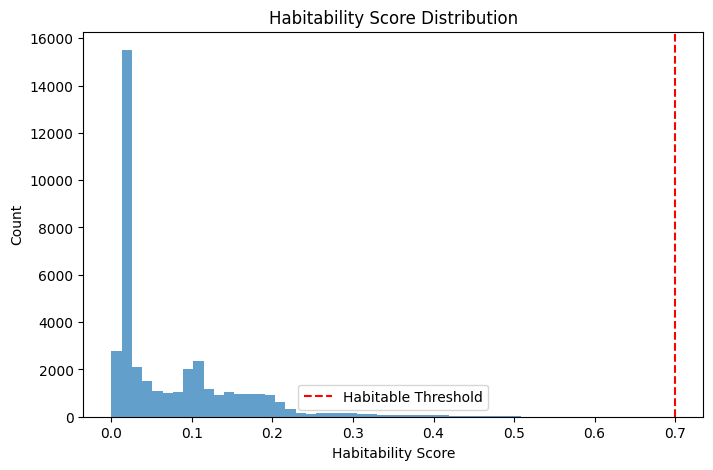

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

df = pd.read_csv("/content/exoplanet_feature_engineered_dataset.csv")

plt.figure(figsize=(8,5))
plt.hist(df["habitability_score"], bins=50, alpha=0.7)
plt.axvline(0.7, color="red", linestyle="--", label="Habitable Threshold")
plt.xlabel("Habitability Score")
plt.ylabel("Count")
plt.title("Habitability Score Distribution")
plt.legend()

# Create the directory if it does not exist
os.makedirs("module7/outputs", exist_ok=True)

plt.savefig("module7/outputs/score_distribution.png")
plt.show()

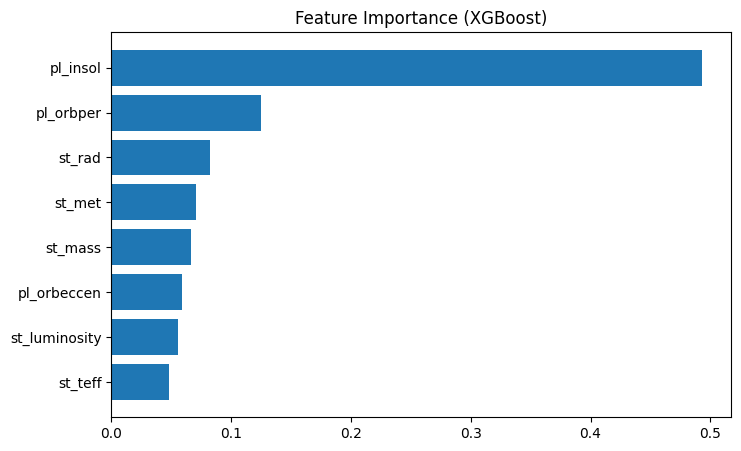

In [ ]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd

model = joblib.load("/content/models/xgboost_reg (1).pkl")
features = joblib.load("/content/models/model_features (1).pkl")

importance = model.feature_importances_
imp_df = pd.DataFrame({
    "feature": features,
    "importance": importance
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (XGBoost)")
plt.savefig("module7/outputs/feature_importance.png")
plt.show()


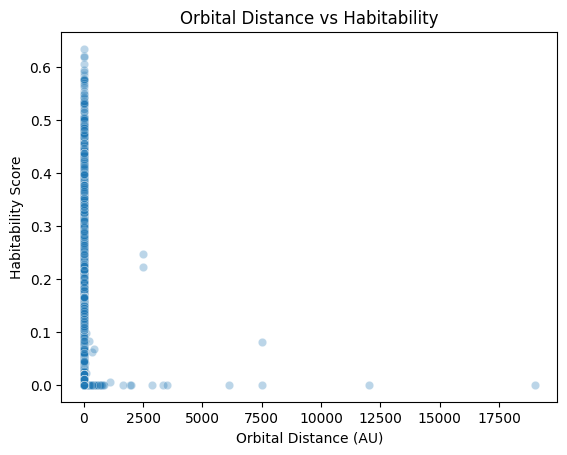

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/exoplanet_feature_engineered_dataset.csv")

sns.scatterplot(x="pl_orbsmax", y="habitability_score", data=df, alpha=0.3)
plt.xlabel("Orbital Distance (AU)")
plt.ylabel("Habitability Score")
plt.title("Orbital Distance vs Habitability")
plt.savefig("module7/outputs/orbit_vs_score.png")
plt.show()


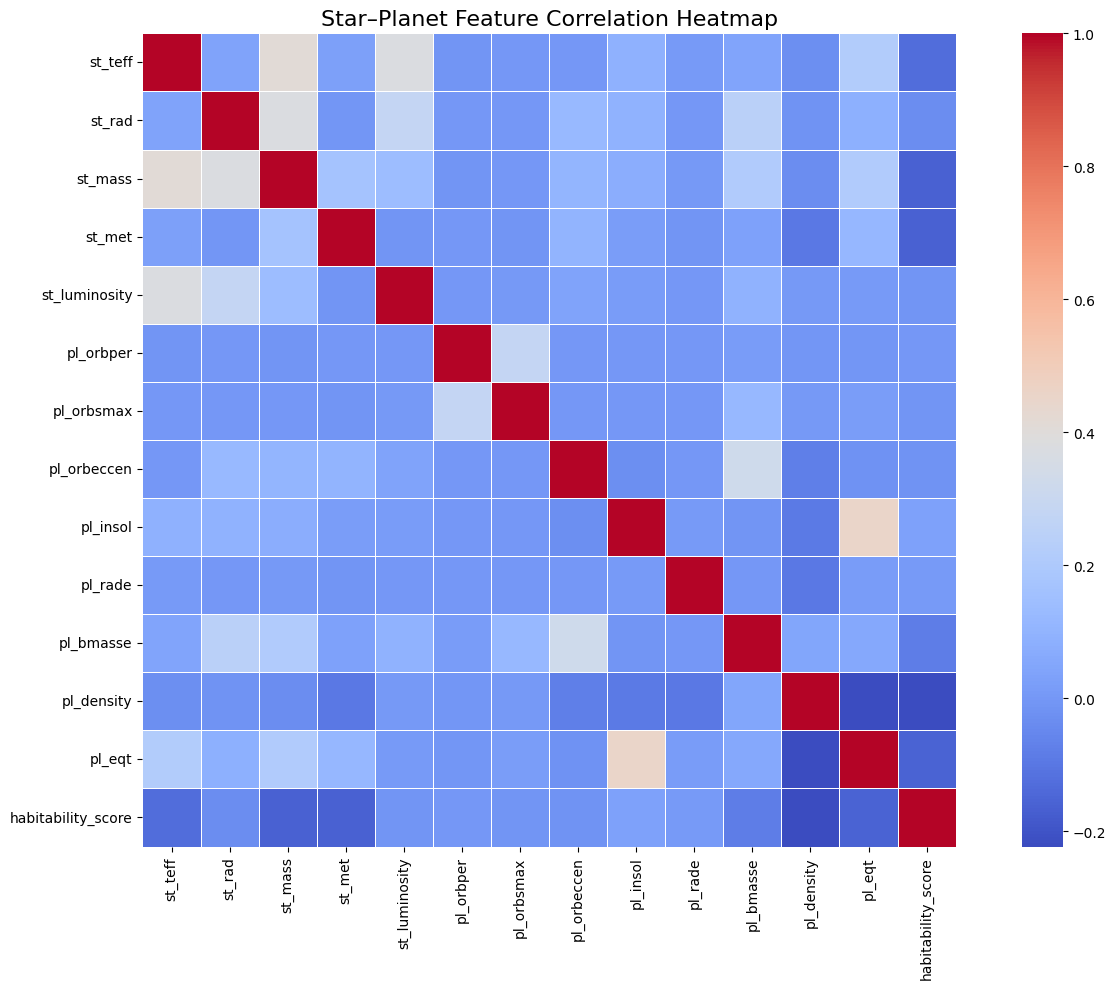

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/exoplanet_feature_engineered_dataset.csv")

FEATURES = [
    "st_teff",
    "st_rad",
    "st_mass",
    "st_met",
    "st_luminosity",
    "pl_orbper",
    "pl_orbsmax",
    "pl_orbeccen",
    "pl_insol",
    "pl_rade",
    "pl_bmasse",
    "pl_density",
    "pl_eqt",
    "habitability_score"
]

# Keep only required numeric columns
df_corr = df[FEATURES].dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    square=True
)

plt.title("Star–Planet Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()

# Save output
plt.savefig("module7/outputs/star_planet_correlation_heatmap.png", dpi=300)
plt.show()
